# Bank Marketing Term Deposit Subscription Prediction : Comparing Classifiers

**Overview**: In this Project, our goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Background

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).


### Objective

Develop a predictive model to assist in targeted marketing efforts aimed at increasing subscription to term deposits. The primary focus of the model should be on accurately identifying customers who are likely to subscribe (i.e., those who have responded positively). While it's acceptable for the model to occasionally misclassify customers who are unlikely to subscribe as potential subscribers, it's crucial to minimize false negatives—instances where actual subscribers are incorrectly classified as non-subscribers. By prioritizing accuracy in identifying potential subscribers, the model aims to optimize resource allocation and maximize the effectiveness of marketing campaigns, ultimately enhancing the bank's subscription rate for term deposits.

## Data Understanding

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.datasets import load_digits
import plotly.express as px
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import logging
import json
import time

In [3]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [4]:
df.head()

age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0          93.994          -36.4      4.857       5191.0  no  
1          93.994          -36.4      4.857       5191.0  no  
2          93.994          -36.4      4.857       5191.0  no  
3          93.994          -36.4      4.857       5191.0  no  
4          93.994          -36.4      4.857       5191.0  no  

[5 rows x 21 columns]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [6]:
df.describe()

age      duration      campaign         pdays      previous  \
count  41188.00000  41188.000000  41188.000000  41188.000000  41188.000000   
mean      40.02406    258.285010      2.567593    962.475454      0.172963   
std       10.42125    259.279249      2.770014    186.910907      0.494901   
min       17.00000      0.000000      1.000000      0.000000      0.000000   
25%       32.00000    102.000000      1.000000    999.000000      0.000000   
50%       38.00000    180.000000      2.000000    999.000000      0.000000   
75%       47.00000    319.000000      3.000000    999.000000      0.000000   
max       98.00000   4918.000000     56.000000    999.000000      7.000000   

       emp.var.rate  cons.price.idx  cons.conf.idx     euribor3m   nr.employed  
count  41188.000000    41188.000000   41188.000000  41188.000000  41188.000000  
mean       0.081886       93.575664     -40.502600      3.621291   5167.035911  
std        1.570960        0.578840       4.628198      1.734447     72.251528  
min       -3.400000       92.201000     -50.800000      0.634000   4963.600000  
25%       -1.800000       93.075000     -42.700000      1.344000   5099.100000  
50%        1.100000       93.749000     -41.800000      4.857000   5191.000000  
75%        1.400000       93.994000     -36.400000      4.961000   5228.100000  
max        1.400000       94.767000     -26.900000      5.045000   5228.100000

#### Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



## Data Exploration

We can see there are 11 categorical features and 10 numerical features. This dataset seems comprehensive and suitable for classification tasks. Before jumping into model building, it's crucial to understand the data. This involves exploring the distributions of features, handling outliers if any, dropping features that may not be useful and understanding the relationships between features and the target variable.

In [7]:
df.head()

age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0          93.994          -36.4      4.857       5191.0  no  
1          93.994          -36.4      4.857       5191.0  no  
2          93.994          -36.4      4.857       5191.0  no  
3          93.994          -36.4      4.857       5191.0  no  
4          93.994          -36.4      4.857       5191.0  no  

[5 rows x 21 columns]

In [8]:
#Visualizing Categorical and Numerical Features seperately
cat_columns = df.select_dtypes(include=['object']).columns.tolist()
numeric_columns = df.select_dtypes(exclude=['object']).columns.tolist()
print("Categorical columns: " + str(cat_columns))
print("Numeric columns: " + str(numeric_columns))

Categorical columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']
Numeric columns: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


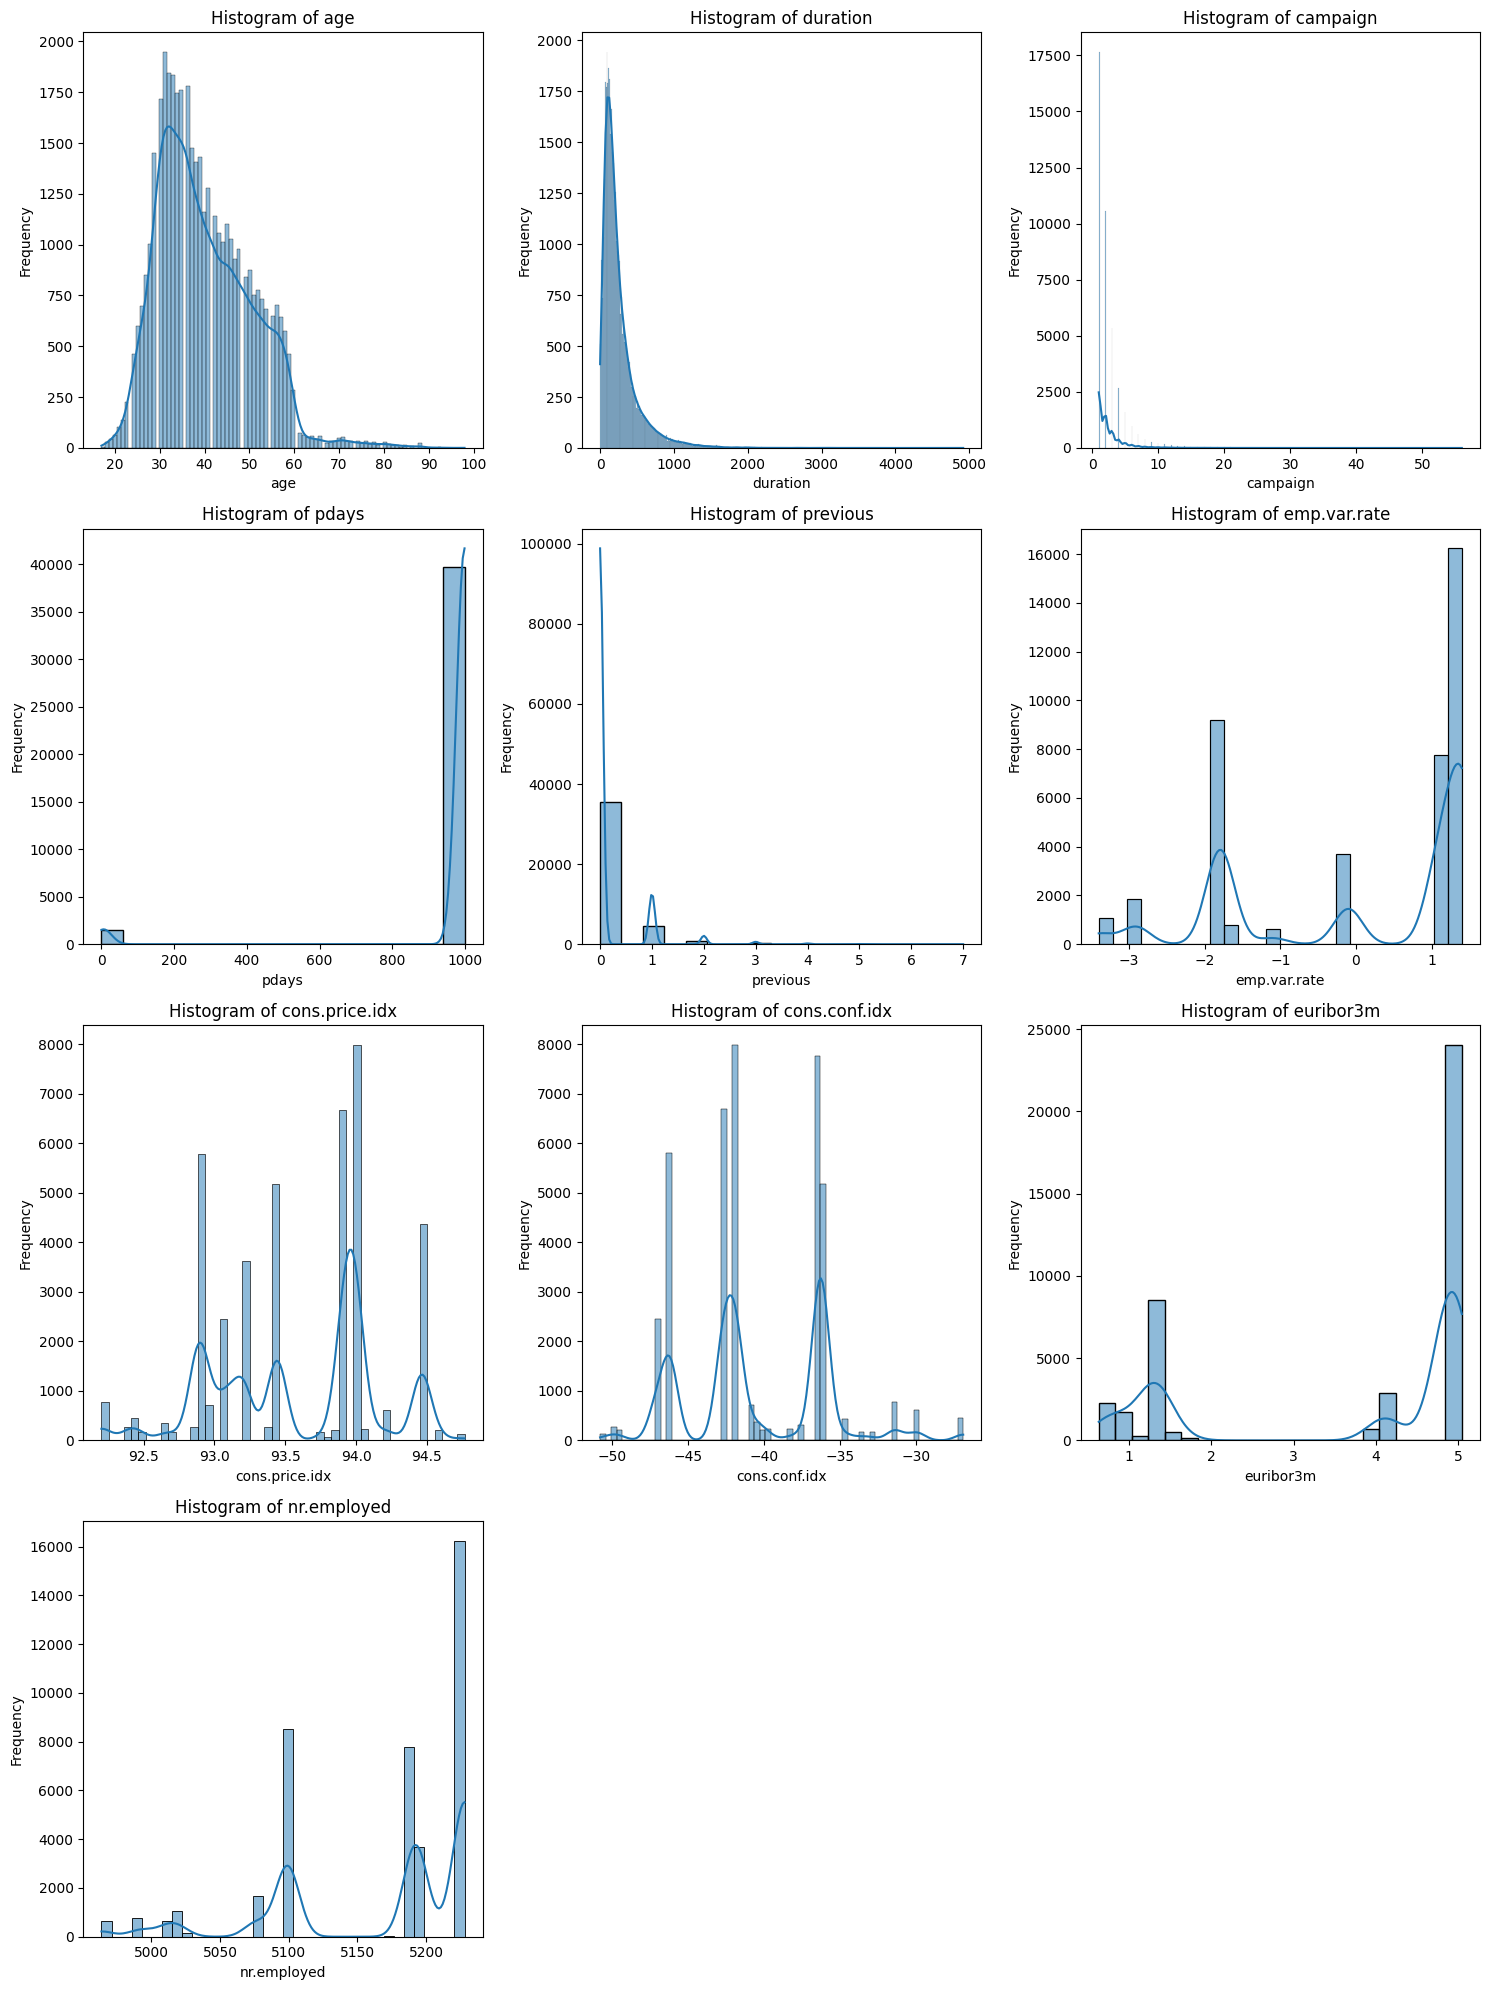

In [9]:
# Calculate the number of rows needed for subplots
num_rows_numeric = (len(numeric_columns) + 2) // 3  # Ceiling division to ensure enough rows
num_rows_cat = (len(cat_columns) + 2) // 3  # Ceiling division to ensure enough rows

# Plotting histograms for numerical features
plt.figure(figsize=(15, 5 * num_rows_numeric))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(num_rows_numeric, 3, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

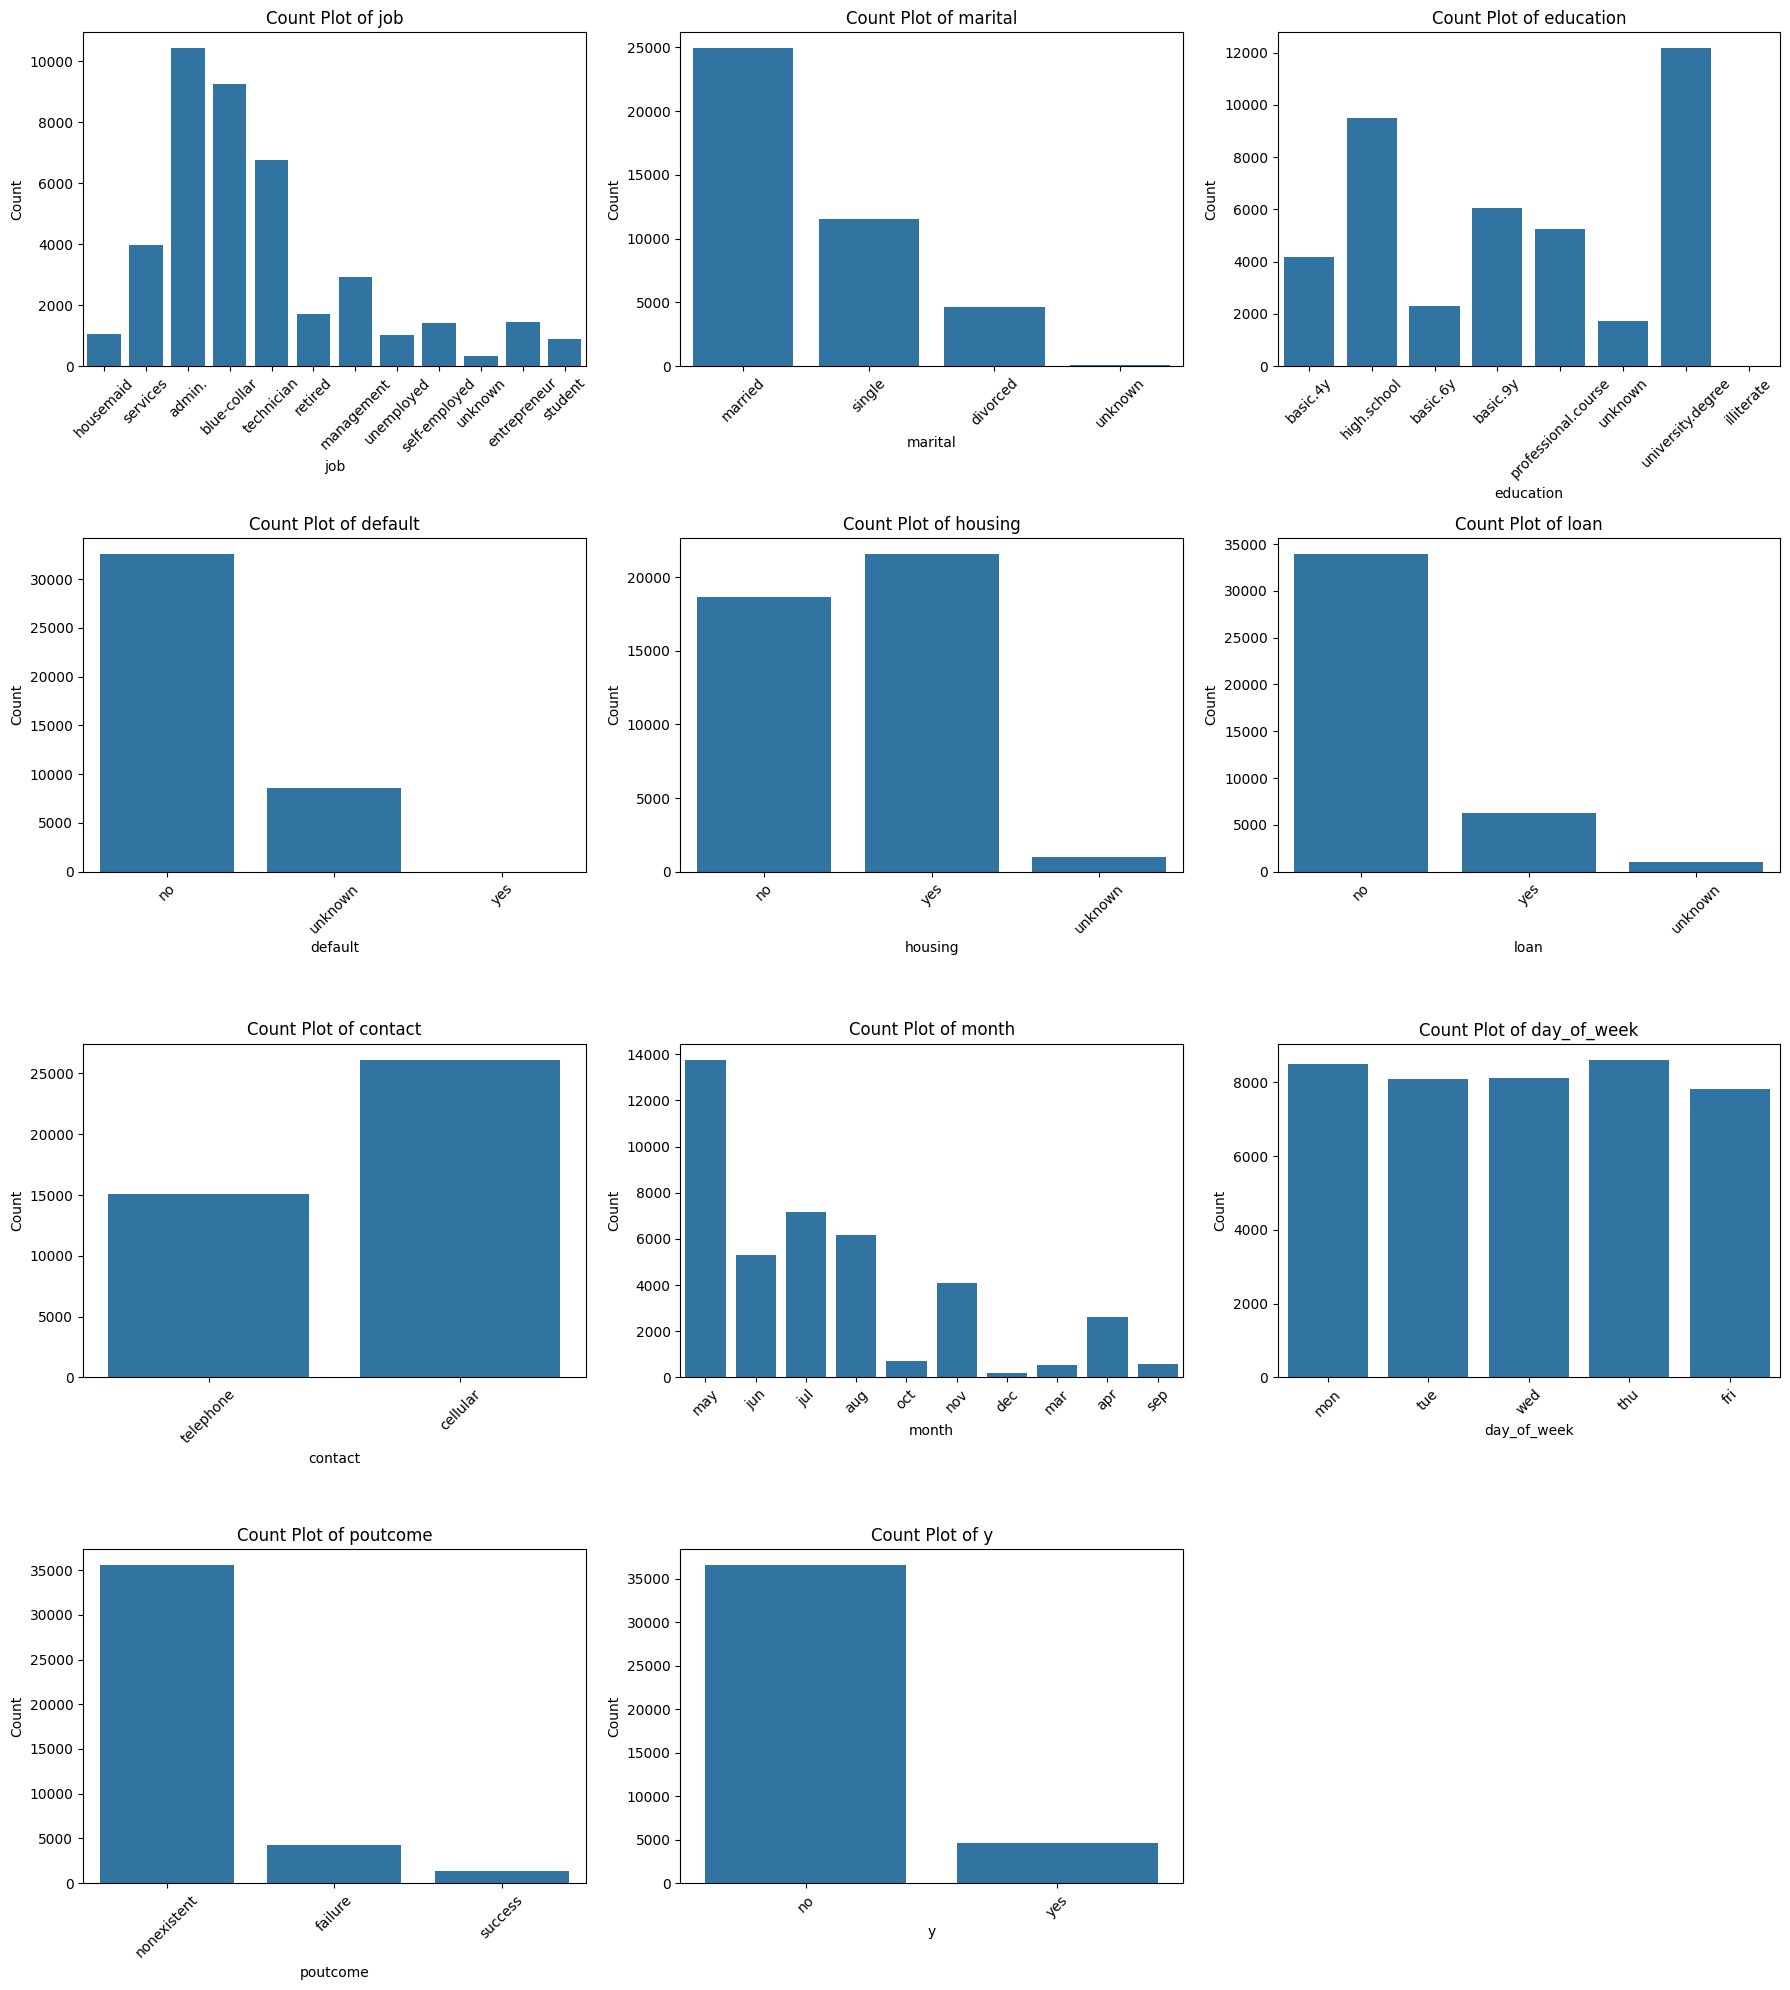

In [10]:
# Plotting count plots for categorical features
plt.figure(figsize=(18, 5 * num_rows_cat))
for i, col in enumerate(cat_columns, 1):
    plt.subplot(num_rows_cat, 3, i)
    sns.countplot(data=df, x=col)
    plt.title(f'Count Plot of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [11]:
#Exploring Features with Unkown aka 'NA' Values
contain_unknown = ['job','marital','education','default','housing','loan']
for col in contain_unknown:
    print(df[col].value_counts())
    print('\n')

job
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: count, dtype: int64


marital
married     24928
single      11568
divorced     4612
unknown        80
Name: count, dtype: int64


education
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: count, dtype: int64


default
no         32588
unknown     8597
yes            3
Name: count, dtype: int64


housing
yes        21576
no         18622
unknown      990
Name: count, dtype: int64


loan
no         33950
yes         6248
unknown      990
Name: count, dtype: int64




In [12]:
# Education Feature can ordinally encoded as there is an inherent Ordinal relationship. 
df['education'].value_counts()

education
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: count, dtype: int64

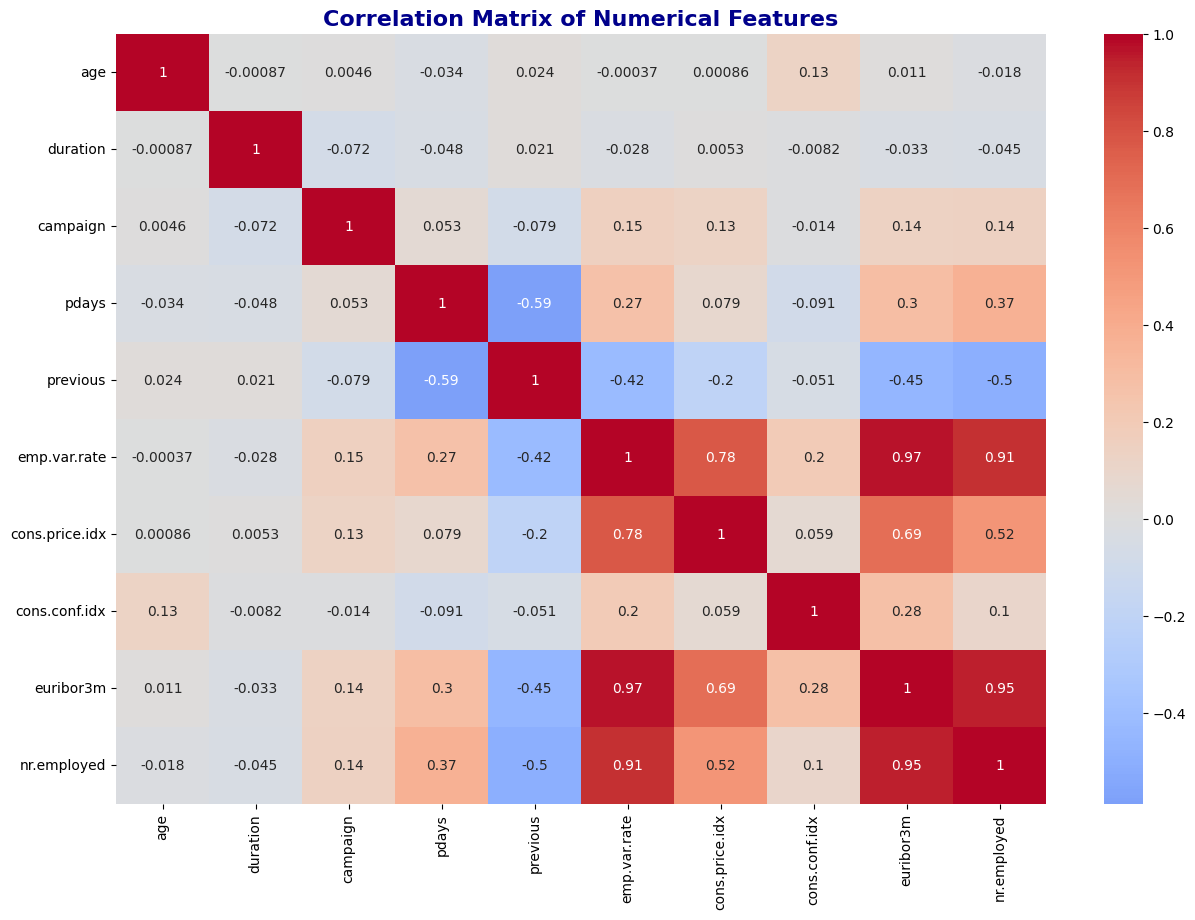

In [13]:
# Calculate the correlation matrix for numerical features
correlation_matrix = df[numeric_columns].corr()

# Plot the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features', fontsize=16, fontweight='bold', color='darkblue')
plt.show()

## Data Cleaning and Preprocessing

- For features like ['job', 'marital', 'education', 'housing', 'loan'] , you can replace "unknown" with the mode of the respective columns or other imputation techniques.
- For 'default', since "unknown" is a significant category and "yes" is extremely rare, you can treat "unknown" as a separate category (No need for imputation)
- Oridinally Encode Education as the education levels can be meaningful to the model and analysis. 
- Remove extreme outliers for Numerical Features.
- Transform Target variable from categorical to int

In [14]:
df_cleaned = df.copy()

In [15]:
df_cleaned.head()

age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0          93.994          -36.4      4.857       5191.0  no  
1          93.994          -36.4      4.857       5191.0  no  
2          93.994          -36.4      4.857       5191.0  no  
3          93.994          -36.4      4.857       5191.0  no  
4          93.994          -36.4      4.857       5191.0  no  

[5 rows x 21 columns]

In [16]:
df_cleaned['y'].value_counts()

y
no     36548
yes     4640
Name: count, dtype: int64

In [17]:
#Transform Target variable from string to int by encoding binary numerical values
target_variable_transform = {'yes': 1 , 'no': 0} # Has the client subscribed a term deposit 'yes' or 'no'

df_cleaned['y'] = df_cleaned['y'].map(target_variable_transform)

#### Imputation treatment for Unknown values intuitively

- job and education : we can split the unknown values between the top 2 modes in the feature.
- marital: we can replace with single as it is in intuitive optimal replacement in the marital status field. 
- housing: replace Unknown with 'no' since it is more likely they do not have a house loan if unrecorded, more likely then not per intuitive approach. 
- loan: using mode, since mode in 'no' same approach where more likely to not have a personal loan if not recorded. Also aligns with the Mode imputation. 

In [18]:
# Helper function to split 'unknown' values between the top 2 modes
def impute_split_unknown(df, column_name):
    # Get the top 2 modes
    top_modes = df[column_name].value_counts().index[:2]
    
    # Number of 'unknown' values
    num_unknowns = df[column_name].value_counts().get('unknown', 0)
    
    if num_unknowns > 0:
        # Split the unknown values approximately equally between the top 2 modes
        split_values = np.random.choice(top_modes, num_unknowns, p=[0.5, 0.5])
        unknown_indices = df[df[column_name] == 'unknown'].index
        
        # Assign the split values to the original DataFrame
        df.loc[unknown_indices, column_name] = split_values
    
    return df

# Apply the split imputation to 'job' and 'education'
df_cleaned = impute_split_unknown(df_cleaned, 'job')
df_cleaned = impute_split_unknown(df_cleaned, 'education')

# Replace unknown values in 'marital' with 'single'
df_cleaned['marital'] = df_cleaned['marital'].replace('unknown', 'single')

# Replace unknown values in 'housing' with 'no'
df_cleaned['housing'] = df_cleaned['housing'].replace('unknown', 'no')

# Replace unknown values in 'loan' with 'no'
df_cleaned['loan'] = df_cleaned['loan'].replace('unknown', 'no')

#### Ordinal Encoding 'Education'

In [19]:
df_cleaned['education'].value_counts()

education
university.degree      13036
high.school            10378
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
illiterate                18
Name: count, dtype: int64

In [20]:
#Mapping oridinal education feature to determined values (0-6)
edu_map = {
    'illiterate': 0,
    'basic.4y': 1,
    'basic.6y': 2,
    'basic.9y': 3,
    'high.school': 4,
    'professional.course': 5,
    'university.degree': 6,
    }

# Apply the mapping to the education column
df_cleaned['education'] = df_cleaned['education'].map(edu_map)

In [21]:
df_cleaned.head(3)

age        job  marital  education  default housing loan    contact month  \
0   56  housemaid  married          1       no      no   no  telephone   may   
1   57   services  married          4  unknown      no   no  telephone   may   
2   37   services  married          4       no     yes   no  telephone   may   

  day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0         mon  ...         1    999         0  nonexistent          1.1   
1         mon  ...         1    999         0  nonexistent          1.1   
2         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed  y  
0          93.994          -36.4      4.857       5191.0  0  
1          93.994          -36.4      4.857       5191.0  0  
2          93.994          -36.4      4.857       5191.0  0  

[3 rows x 21 columns]

- 'pdays'
  - number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

In [22]:
# Get counts of unique values in 'pdays'
pdays_counts = df_cleaned['pdays'].value_counts().reset_index()
pdays_counts.columns = ['pdays', 'count']

In [23]:
per_not_contact_prior = pdays_counts[pdays_counts['pdays'] == 999]['count']/pdays_counts['count'].sum()
print("Clients not contact prior to this campaign to all clients: " + str(per_not_contact_prior))

Clients not contact prior to this campaign to all clients: 0    0.963217
Name: count, dtype: float64


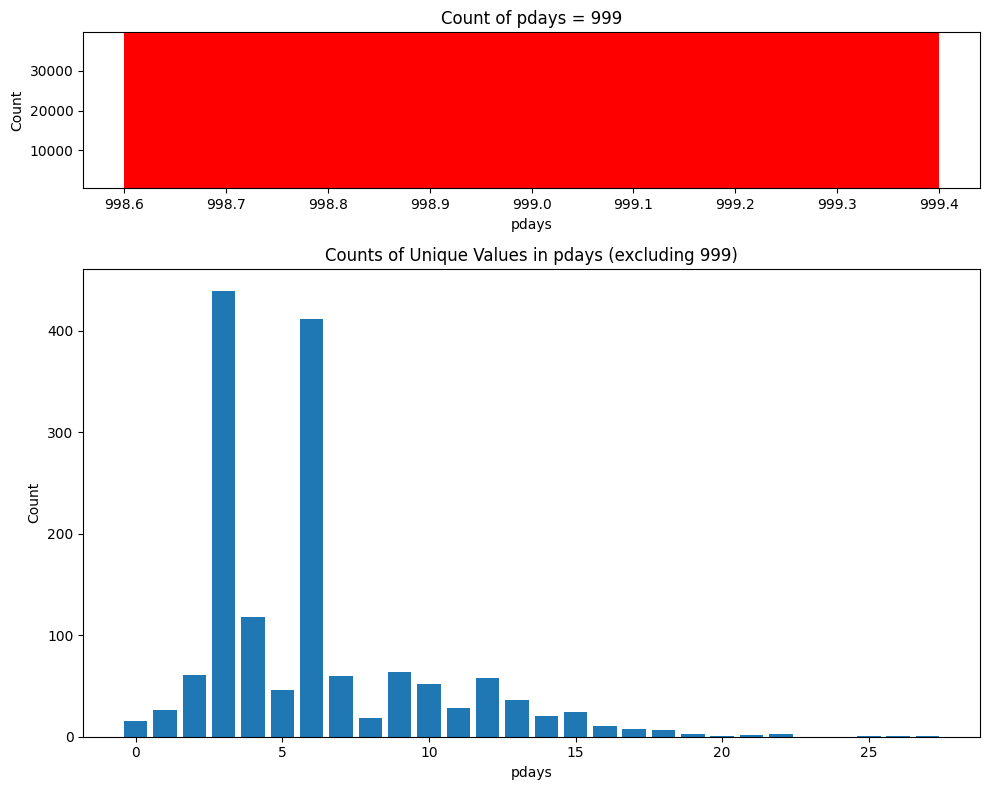

In [24]:
# Separate the count of 999 from the rest
pdays_999_count = pdays_counts[pdays_counts['pdays'] == 999]
pdays_other_counts = pdays_counts[pdays_counts['pdays'] != 999]

# Plotting the counts
fig, ax = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [1, 3]})

# Plot the count of 999
ax[0].bar(pdays_999_count['pdays'], pdays_999_count['count'], color='red')
ax[0].set_xlabel('pdays')
ax[0].set_ylabel('Count')
ax[0].set_title('Count of pdays = 999')
ax[0].set_ylim(pdays_other_counts['count'].max(), pdays_999_count['count'].max() + 10)

# Plot the counts of other values
ax[1].bar(pdays_other_counts['pdays'], pdays_other_counts['count'])
ax[1].set_xlabel('pdays')
ax[1].set_ylabel('Count')
ax[1].set_title('Counts of Unique Values in pdays (excluding 999)')

plt.tight_layout()
plt.show()



From the plot above, it is clear that the value '999' in pdays attribute is significantly higher than all the other unique values put together. This means about 96.32% of the clients were not contacted prior to this campaign resulting high skewed data for 'pdays'. I believe we can tranform this feature by creating a new feature that exhibits whether a client has been previously contacted or not. The quantity of previous contact poses no real insight due to lack of data in comparison to the value of the 'pdays' features that represents clients have not been contact previously. 

A new feature 'pre_contact' will be created from 'pday' and then 'pdays' will be dropped. 

In [25]:
# Create the new feature 'pre_contact'
df_cleaned['pre_contact'] = df_cleaned['pdays'].apply(lambda x: 'no' if x == 999 else 'yes')
# Drop the original 'pdays' column
df_cleaned.drop(columns=['pdays'], inplace=True)

#### Remove Extreme outlier for Numerical Features

In [26]:
print(numeric_columns) # ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


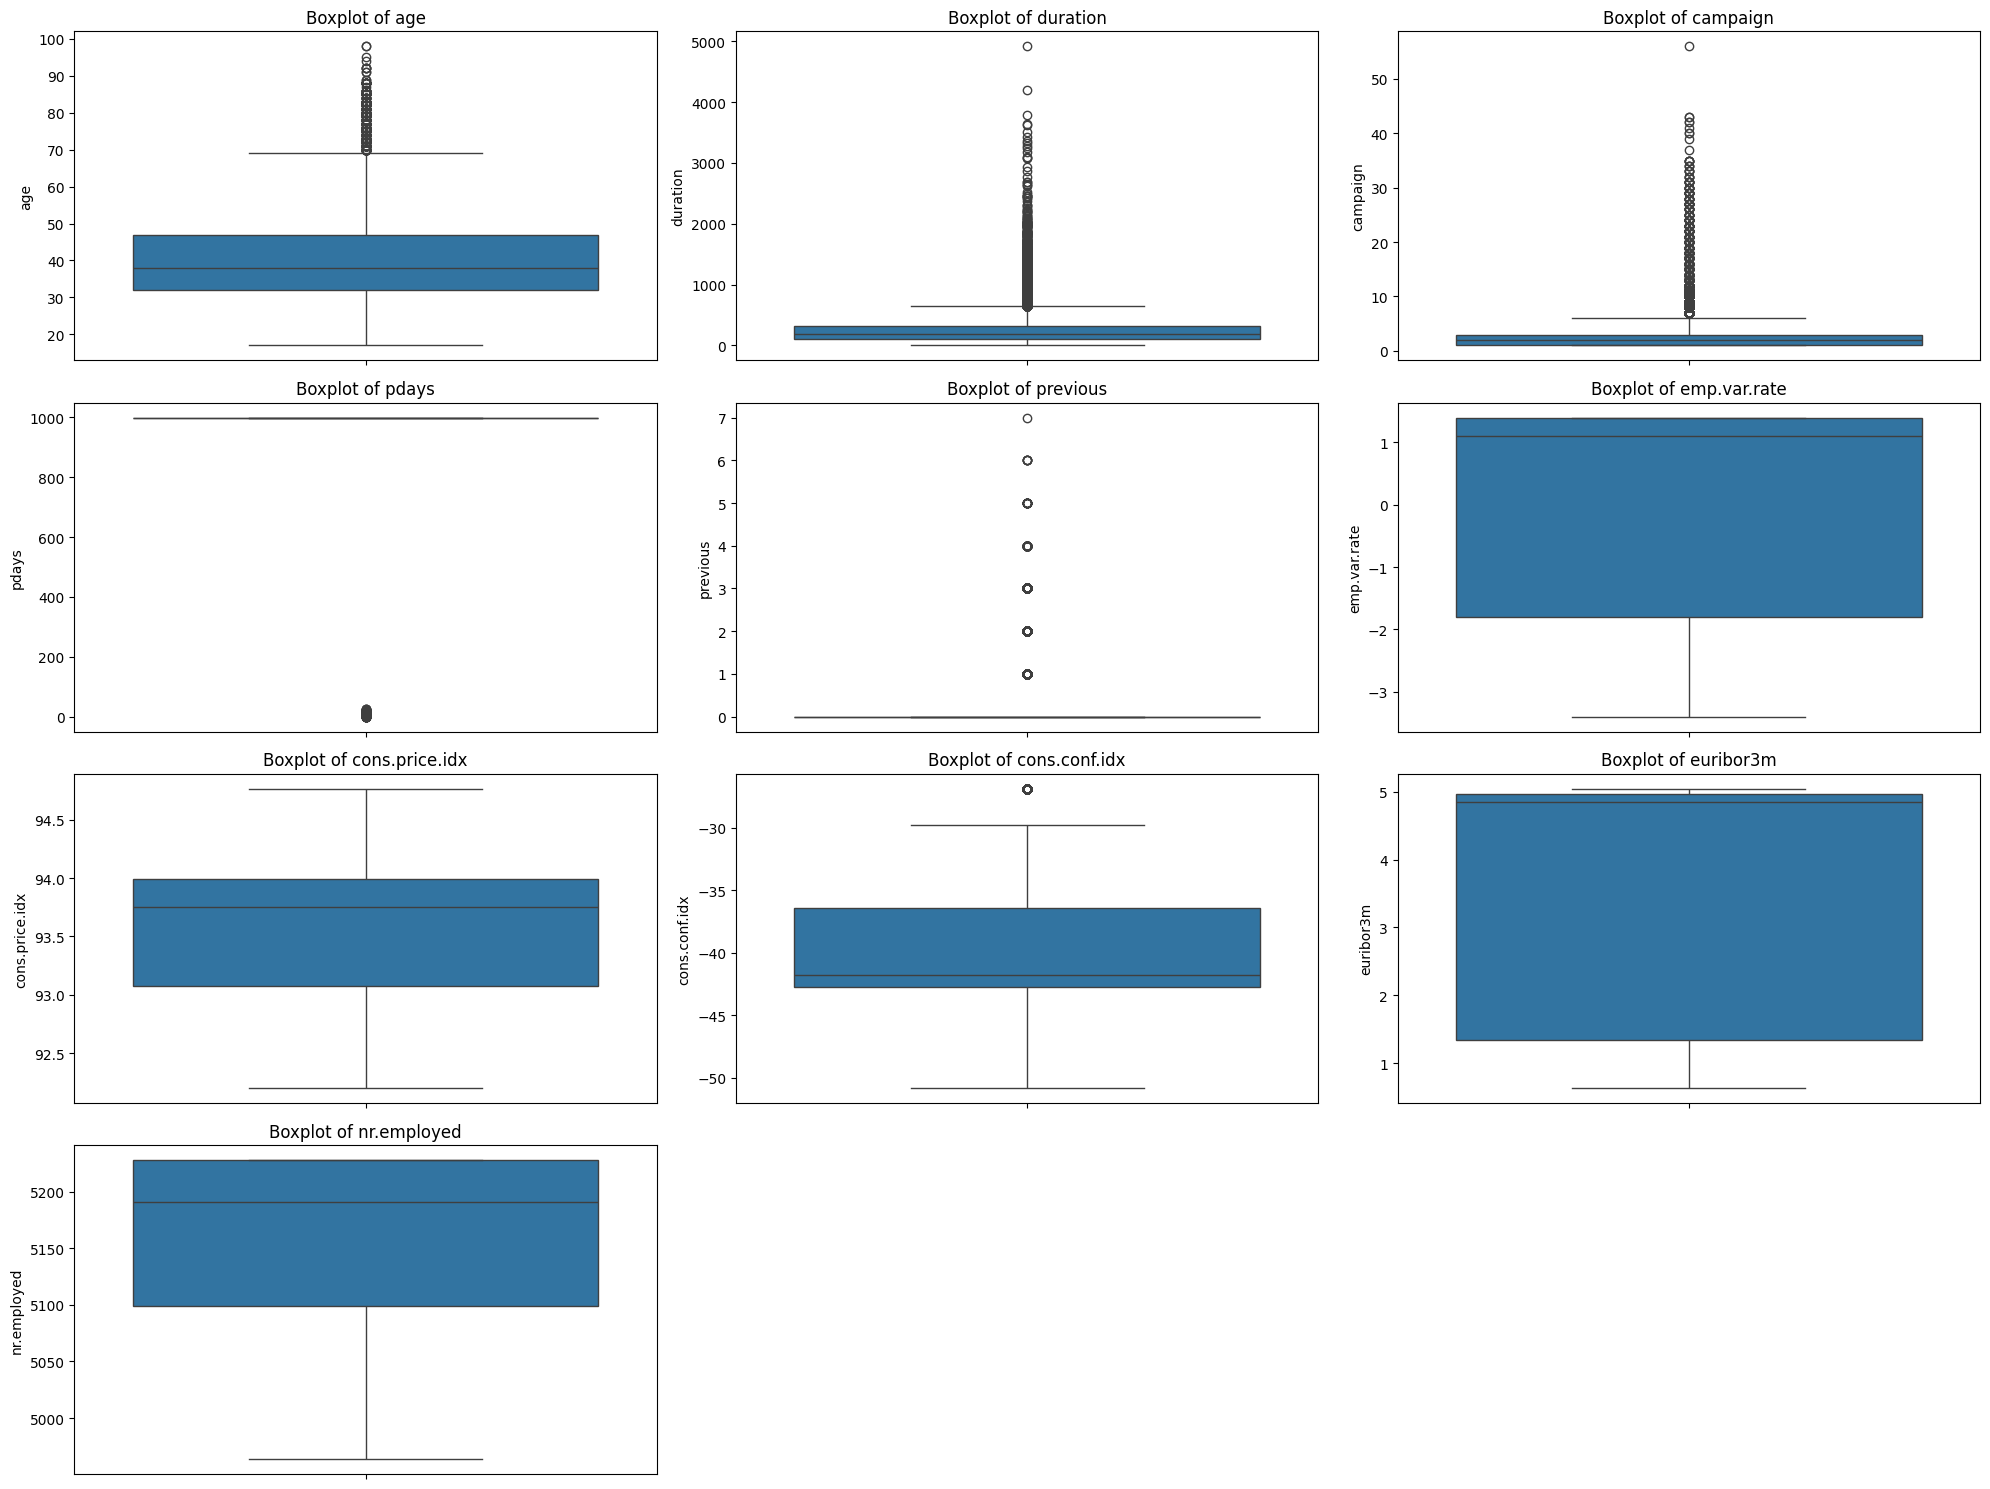

In [27]:
#Observing Outliers for Numerically distributed attributes

# Plot boxplots
plt.figure(figsize=(20, 15))  # Adjust the figure size as needed

for i, col in enumerate(numeric_columns):
    plt.subplot(len(numeric_columns) // 3 + 1, 3, i + 1)  # Create subplots
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')

plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()


In [28]:
df_cleaned.describe()

age     education      duration      campaign      previous  \
count  41188.00000  41188.000000  41188.000000  41188.000000  41188.000000   
mean      40.02406      4.196319    258.285010      2.567593      0.172963   
std       10.42125      1.625935    259.279249      2.770014      0.494901   
min       17.00000      0.000000      0.000000      1.000000      0.000000   
25%       32.00000      3.000000    102.000000      1.000000      0.000000   
50%       38.00000      4.000000    180.000000      2.000000      0.000000   
75%       47.00000      6.000000    319.000000      3.000000      0.000000   
max       98.00000      6.000000   4918.000000     56.000000      7.000000   

       emp.var.rate  cons.price.idx  cons.conf.idx     euribor3m  \
count  41188.000000    41188.000000   41188.000000  41188.000000   
mean       0.081886       93.575664     -40.502600      3.621291   
std        1.570960        0.578840       4.628198      1.734447   
min       -3.400000       92.201000     -50.800000      0.634000   
25%       -1.800000       93.075000     -42.700000      1.344000   
50%        1.100000       93.749000     -41.800000      4.857000   
75%        1.400000       93.994000     -36.400000      4.961000   
max        1.400000       94.767000     -26.900000      5.045000   

        nr.employed             y  
count  41188.000000  41188.000000  
mean    5167.035911      0.112654  
std       72.251528      0.316173  
min     4963.600000      0.000000  
25%     5099.100000      0.000000  
50%     5191.000000      0.000000  
75%     5228.100000      0.000000  
max     5228.100000      1.000000

- Exploring and preprocessing outliers for selected features. 

  - 13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
  - 14 - previous: number of contacts performed before this campaign and for this client (numeric)

- 'Previous'

In [29]:
# Calculate value counts for 'previous' column
previous_counts = df_cleaned['previous'].value_counts().reset_index()
previous_counts.columns = ['previous', 'count']

# Create bar graph using Plotly
fig = px.bar(previous_counts, x='previous', y='count', text='count', 
             labels={'previous': 'Previous', 'count': 'Count'},
             title='Value Counts of "previous" Column with Hover Labels',
             hover_data={'count': True},
             color_discrete_sequence=['blue'])

# Update layout for better readability
fig.update_layout(xaxis_title='Previous', yaxis_title='Count')

# Show the figure
fig.show()

In [30]:
'''Previous' represents the number of contacts performed with this client before this campaign. Since there are significantly fewer data points for 5-7 contacts, 
it can confidently be eastablished that these datapoints are outliers and may effect the model when trained including this feature.

Intuitively, the unique value 4 can be merged with 5 through 7 to represent few or more contacts. Hence 5,6,7 values replaced with '4' 
'''

previous_contacts_map = {0:0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 4, 6: 4, 7: 4}
#After applying this mapping, the 'previous' column will have a new category '4' representing "few or more contacts," which can potentially improve the interpretability and robustness of the models.

df_cleaned['previous'] = df_cleaned['previous'].map(previous_contacts_map) 
df_cleaned['previous'].value_counts()

previous
0    35563
1     4561
2      754
3      216
4       94
Name: count, dtype: int64

- 'Duration'

duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

In [31]:
df_cleaned.drop('duration', axis = 1, inplace = True)

- 'Campaign' 
  - number of contacts performed during this campaign and for this client (numeric, includes last contact)

In [32]:
df_cleaned['campaign'].value_counts().sort_values(ascending= False)

campaign
1     17642
2     10570
3      5341
4      2651
5      1599
6       979
7       629
8       400
9       283
10      225
11      177
12      125
13       92
14       69
17       58
16       51
15       51
18       33
20       30
19       26
21       24
22       17
23       16
24       15
27       11
29       10
28        8
26        8
25        8
31        7
30        7
35        5
33        4
32        4
34        3
42        2
40        2
43        2
56        1
39        1
41        1
37        1
Name: count, dtype: int64

In [33]:
total_camp = len(df_cleaned['campaign'])
total_camp

41188

In [34]:
print("Campaign unique values: " + str(df_cleaned['campaign'].value_counts().count()))

threshold = 12
camp_thresh_count = df_cleaned[df_cleaned['campaign'] >= i].loc[:,'campaign'].count()
total_camp = df_cleaned.shape[0]
print(f"\nNumber data points on campaign above {threshold} contact performed during this campaign: " + str(camp_thresh_count))
print("\nAbove Threshold data points ratio to all datapoints: " + str(round(camp_thresh_count/total_camp * 100,2)) + "%")

Campaign unique values: 42

Number data points on campaign above 12 contact performed during this campaign: 1377

Above Threshold data points ratio to all datapoints: 3.34%


In [35]:
'''It looks like there are extreme number of outliers that maybe not be suitable for training. Due to the nature of the feature, it is reasonable to replace outlier values with a reasonable
exisitng value to represent a group. Let us take 12 as a threshold where all values above 12 will be replaced, repurposing '12' as 'campagn contacts 12 or more'. 
This does pose a risk to the integrity of the model or training process as this would only effect a very small portion (1.68%) of one feature where the manipulated data points are deamed outliers.'''

# Replace values greater than 12 with 12 in the 'campaign' feature
df_cleaned['campaign'] = df_cleaned['campaign'].apply(lambda x: 12 if x > 12 else x)

# Verify the replacement
print(df_cleaned['campaign'].value_counts().sort_values(ascending=False))

campaign
1     17642
2     10570
3      5341
4      2651
5      1599
6       979
12      692
7       629
8       400
9       283
10      225
11      177
Name: count, dtype: int64


- social and economic context attributes
  - 16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
  - 17 - cons.price.idx: consumer price index - monthly indicator (numeric)
  - 18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
  - 19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
  - 20 - nr.employed: number of employees - quarterly indicator (numeric)

These features are related to economic indicators and are commonly used in financial and economic analyses. Here's a brief explanation of each:

- emp.var.rate (Employment Variation Rate):
  - This represents the quarterly indicator of the employment variation rate. It reflects changes in the level of employment over time. A positive value indicates an increase in employment, while a negative value indicates a decrease. This indicator is often used to assess the overall health of the job market and the economy's performance.

- cons.price.idx (Consumer Price Index):
  - This is a monthly indicator of the consumer price index. The consumer price index measures the average change over time in the prices paid by urban consumers for a basket of consumer goods and services. It is a key measure of inflation and is widely used by economists, policymakers, and investors to gauge changes in the cost of living and purchasing power.

- cons.conf.idx (Consumer Confidence Index):
  - This is a monthly indicator of the consumer confidence index. The consumer confidence index measures consumers' sentiment and outlook about the economy's future performance. It reflects consumers' assessments of current economic conditions, employment prospects, income expectations, and overall economic outlook. Changes in consumer confidence can influence consumer spending behavior, investment decisions, and overall economic activity.

- euribor3m (EURIBOR 3 Month Rate):
  - This represents the daily indicator of the EURIBOR 3-month rate. EURIBOR (Euro Interbank Offered Rate) is the average interest rate at which European banks offer to lend funds to one another in the interbank market. The 3-month rate is one of the most widely used benchmark interest rates in the eurozone. It is a key reference rate for various financial products, including mortgages, loans, and derivatives.

- nr.employed (Number of Employees):
  - This represents the quarterly indicator of the number of employees. It reflects changes in the total number of employed workers in the economy over time. This indicator is often used to assess labor market conditions, employment trends, and overall economic activity.
These features provide insights into different aspects of the economy, including employment dynamics, price levels, consumer sentiment, and interest rate trends. Analysts often use these indicators to monitor economic performance, forecast future trends, and make informed decisions in various sectors, including finance, business, and policymaking.

In [36]:
df_cleaned

age          job  marital  education  default housing loan    contact  \
0       56    housemaid  married          1       no      no   no  telephone   
1       57     services  married          4  unknown      no   no  telephone   
2       37     services  married          4       no     yes   no  telephone   
3       40       admin.  married          2       no      no   no  telephone   
4       56     services  married          4       no      no  yes  telephone   
...    ...          ...      ...        ...      ...     ...  ...        ...   
41183   73      retired  married          5       no     yes   no   cellular   
41184   46  blue-collar  married          5       no      no   no   cellular   
41185   56      retired  married          6       no     yes   no   cellular   
41186   44   technician  married          5       no      no   no   cellular   
41187   74      retired  married          5       no     yes   no   cellular   

      month day_of_week  campaign  previous     poutcome  emp.var.rate  \
0       may         mon         1         0  nonexistent           1.1   
1       may         mon         1         0  nonexistent           1.1   
2       may         mon         1         0  nonexistent           1.1   
3       may         mon         1         0  nonexistent           1.1   
4       may         mon         1         0  nonexistent           1.1   
...     ...         ...       ...       ...          ...           ...   
41183   nov         fri         1         0  nonexistent          -1.1   
41184   nov         fri         1         0  nonexistent          -1.1   
41185   nov         fri         2         0  nonexistent          -1.1   
41186   nov         fri         1         0  nonexistent          -1.1   
41187   nov         fri         3         1      failure          -1.1   

       cons.price.idx  cons.conf.idx  euribor3m  nr.employed  y pre_contact  
0              93.994          -36.4      4.857       5191.0  0          no  
1              93.994          -36.4      4.857       5191.0  0          no  
2              93.994          -36.4      4.857       5191.0  0          no  
3              93.994          -36.4      4.857       5191.0  0          no  
4              93.994          -36.4      4.857       5191.0  0          no  
...               ...            ...        ...          ... ..         ...  
41183          94.767          -50.8      1.028       4963.6  1          no  
41184          94.767          -50.8      1.028       4963.6  0          no  
41185          94.767          -50.8      1.028       4963.6  0          no  
41186          94.767          -50.8      1.028       4963.6  1          no  
41187          94.767          -50.8      1.028       4963.6  0          no  

[41188 rows x 20 columns]

In [37]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  int64  
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  campaign        41188 non-null  int64  
 11  previous        41188 non-null  int64  
 12  poutcome        41188 non-null  object 
 13  emp.var.rate    41188 non-null  float64
 14  cons.price.idx  41188 non-null  float64
 15  cons.conf.idx   41188 non-null  float64
 16  euribor3m       41188 non-null  float64
 17  nr.employed     41188 non-null 

In [38]:
cat_columns = df_cleaned.select_dtypes(include=['object']).columns.tolist()
numeric_columns = df_cleaned.select_dtypes(exclude=['object']).columns.tolist()
numeric_columns.remove('y')
print("Categorical columns: " + str(cat_columns))
print("Numeric columns: " + str(numeric_columns))

Categorical columns: ['job', 'marital', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'pre_contact']
Numeric columns: ['age', 'education', 'campaign', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


In [39]:
df_cleaned[cat_columns].head()

job  marital  default housing loan    contact month day_of_week  \
0  housemaid  married       no      no   no  telephone   may         mon   
1   services  married  unknown      no   no  telephone   may         mon   
2   services  married       no     yes   no  telephone   may         mon   
3     admin.  married       no      no   no  telephone   may         mon   
4   services  married       no      no  yes  telephone   may         mon   

      poutcome pre_contact  
0  nonexistent          no  
1  nonexistent          no  
2  nonexistent          no  
3  nonexistent          no  
4  nonexistent          no

## Engineering Features

Now that we understand our business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

Approach: Create a Transformer to encode features before modeling

  - One-Hot Encoding: For nominal categorical variables without any ordinal relationship (e.g., job, marital, contact, poutcome, pre_contact,month, day_of_week).
  - Binary Encoding: For binary variables that have only two possible values (e.g., default, housing, loan).
  - Standardization/Normalization: For numeric features to scale them appropriately.

In [40]:
# Create the column transformer with appropriate encodings
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),
        ('job_marital_contact_poutcome_pre_contact', OneHotEncoder(), ['job', 'marital', 'contact', 'poutcome', 'pre_contact']),
        ('default_housing_loan', OneHotEncoder(drop='if_binary'), ['default', 'housing', 'loan']),
        ('month_day', OneHotEncoder(), ['month', 'day_of_week'])
    ]
)

In [41]:
# Separate features and target
X = df_cleaned.drop(columns=['y'])
y = df_cleaned['y']  # No need to encode y since it's already numeric

# Fit and transform the feature data
X_transformed = preprocessor.fit_transform(X)

# Convert the transformed data back to a DataFrame for better readability
ohe_columns_job_marital_contact_poutcome_pre_contact = preprocessor.named_transformers_['job_marital_contact_poutcome_pre_contact'].get_feature_names_out(['job', 'marital', 'contact', 'poutcome', 'pre_contact']).tolist()
ohe_columns_default_housing_loan = preprocessor.named_transformers_['default_housing_loan'].get_feature_names_out(['default', 'housing', 'loan']).tolist()
ohe_columns_month_day = preprocessor.named_transformers_['month_day'].get_feature_names_out(['month', 'day_of_week']).tolist()

all_columns = numeric_columns + ohe_columns_job_marital_contact_poutcome_pre_contact + ohe_columns_default_housing_loan + ohe_columns_month_day

X_transformed_df = pd.DataFrame(X_transformed, columns=all_columns)

print(X_transformed_df.head())

# Print shapes to ensure correctness
print("Shape of transformed X:", X_transformed_df.shape)
print("Shape of target y:", y.shape)

        age  education  campaign  previous  emp.var.rate  cons.price.idx  \
0  1.533034  -1.965859 -0.675537 -0.352983      0.648092        0.722722   
1  1.628993  -0.120744 -0.675537 -0.352983      0.648092        0.722722   
2 -0.290186  -0.120744 -0.675537 -0.352983      0.648092        0.722722   
3 -0.002309  -1.350821 -0.675537 -0.352983      0.648092        0.722722   
4  1.533034  -0.120744 -0.675537 -0.352983      0.648092        0.722722   

   cons.conf.idx  euribor3m  nr.employed  job_admin.  ...  month_mar  \
0       0.886447    0.71246      0.33168         0.0  ...        0.0   
1       0.886447    0.71246      0.33168         0.0  ...        0.0   
2       0.886447    0.71246      0.33168         0.0  ...        0.0   
3       0.886447    0.71246      0.33168         1.0  ...        0.0   
4       0.886447    0.71246      0.33168         0.0  ...        0.0   

   month_may  month_nov  month_oct  month_sep  day_of_week_fri  \
0        1.0        0.0        0.0        0.

## Train/Test Split

With your data prepared, split it into a train and test set.

In [42]:
# Split the data into features (X) and target (y)
X = df_cleaned.drop('y', axis=1)  # Features
y = df_cleaned['y']  # Target

# Split the data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the train and test sets
print("Train set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Train set shape: (32950, 19) (32950,)
Test set shape: (8238, 19) (8238,)


## A Baseline for Models

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

The baseline performance for a classification problem can be established by simply considering the distribution of the target variable and predicting the majority class for all instances in the test set.

In this case, since the target variable 'y' represents whether a client subscribed to a term deposit ('yes' or 'no'), we can calculate the percentage of 'yes' and 'no' instances in our test set. The majority class (the most frequent outcome) will determine the baseline accuracy.

For example:

If 80% of the instances in the test set belong to class 'no' and 20% belong to class 'yes', the baseline accuracy would be 80%. This means that a simple model that predicts 'no' for every instance would achieve an accuracy of 80%.

## A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [43]:
# Define the Logistic Regression model
logistic_model = LogisticRegression(random_state=42)

# Create a pipeline with preprocessing and the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', logistic_model)
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'education',
                                                   'campaign', 'previous',
                                                   'emp.var.rate',
                                                   'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed']),
                                                 ('job_marital_contact_poutcome_pre_contact',
                                                  OneHotEncoder(),
                                                  ['job', 'marital', 'contact',
                                                   'poutcome', 'pre_contact']),
                                                 ('default_housing_loan',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['default', 'housing',
                                                   'loan']),
                                                 ('month_day', OneHotEncoder(),
                                                  ['month', 'day_of_week'])])),
                ('classifier', LogisticRegression(random_state=42))])

### Score the Model

What is the accuracy of the model?

In [44]:
# Predict on the test data
y_pred = pipeline.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8971837824714737


## Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Presenting our findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [73]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'SVM': SVC(random_state=42)
}

# Initialize an empty list to store results
results_1 = []

# Iterate over models
for model_name, model in models.items():
    # Start time
    start_time = time.time()
    
    #Pipeline
    pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
    ])
    
    # Fit the model
    pipeline.fit(X_train, y_train)
    
    # End time
    end_time = time.time()
    
    # Train time
    train_time = end_time - start_time
    
    # Train accuracy
    train_accuracy = pipeline.score(X_train, y_train)
    
    # Test accuracy
    test_accuracy = pipeline.score(X_test, y_test)
    

    #Recall Score
    y_preds = pipeline.predict(X_test)
    recall_score_test_data = recall_score(y_test, y_preds)
    
    # Append results to list
    results_1.append({
        'Model': model_name,
        'Train Time': train_time,
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy,
        'recall Score test data': recall_score_test_data
    })

# Convert results list to DataFrame
results_df_1 = pd.DataFrame(results_1)

# Display results
results_df_1

Model  Train Time  Train Accuracy  Test Accuracy  \
0  Logistic Regression    0.146033        0.901244       0.897184   
1                  KNN    0.062014        0.914568       0.888444   
2        Decision Tree    0.256058        0.995053       0.837703   
3                  SVM   42.335808        0.905099       0.896941   

   recall Score test data  
0                0.212834  
1                0.285561  
2                0.332620  
3                0.244920

It seems like all the models have performed reasonably well, but there are differences in their training times and accuracies.

- Logistic Regression has a relatively low training time and good accuracies on both the training and test sets.
- KNN also has a low training time, but its test accuracy is slightly lower compared to Logistic Regression.
- Decision Tree has the highest training accuracy, indicating potential overfitting, and its test accuracy is lower compared to the other models.
- SVM has the highest training time among all models, but its accuracies are similar to Logistic Regression.

Overall, Logistic Regression seems to be a good choice as it achieves a good balance between training time and accuracy on both training and test sets. However, depending on the specific requirements of your application, you may choose a different model.

## Exploring our Models

- KNN Model

In [46]:
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
    ])

In [47]:
knn_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'education',
                                                   'campaign', 'previous',
                                                   'emp.var.rate',
                                                   'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed']),
                                                 ('job_marital_contact_poutcome_pre_contact',
                                                  OneHotEncoder(),
                                                  ['job', 'marital', 'contact',
                                                   'poutcome', 'pre_contact']),
                                                 ('default_housing_loan',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['default', 'housing',
                                                   'loan']),
                                                 ('month_day', OneHotEncoder(),
                                                  ['month', 'day_of_week'])])),
                ('classifier', KNeighborsClassifier())])

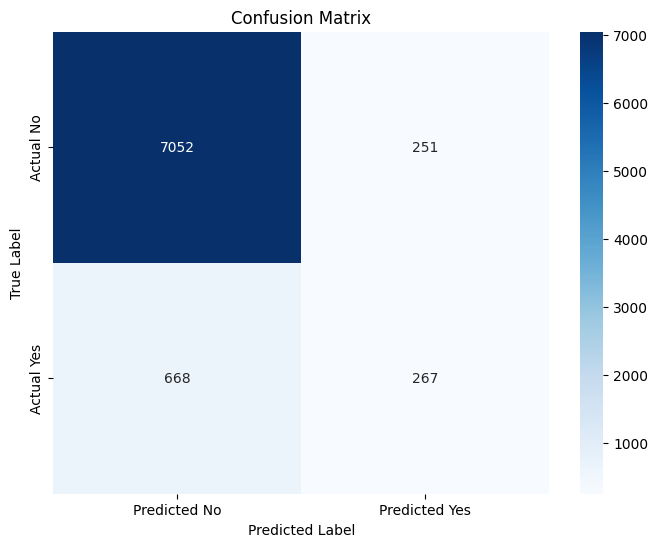

In [48]:
knn_y_pred = knn_pipeline.predict(X_test)

knn_conf_matrix = confusion_matrix(y_test, knn_y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(knn_conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['Actual No', 'Actual Yes'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [49]:
# Calculate recall score
recall = recall_score(y_test, knn_y_pred)

print("Recall Score:", recall)

Recall Score: 0.28556149732620323


Based on the models above, we can see that the recall score is relatively low amonst all the models. It is important to remember how objective is to limit the inaccurate predictions for Actual 'Yes' values in 'y' target feature. Since we are looking to capture customers who are likely to say yes to the term deposit subscription.

Models need to be imrpoved to increase recall score.

## Improving the Models

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep a certain feature?  Why or why not?
- Focus on improving decreasing false negatives or improving RECALL_SCORE
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

#### GridSearch our Models to experiment with different hyperparameters

In [75]:
# Define models with parameter grids
models = {
    'Logistic Regression': (LogisticRegression(random_state=42), {'classifier__C': [0.01, 0.1, 1.0]}),
    'KNN': (KNeighborsClassifier(), {'classifier__n_neighbors': [3, 5, 7]}),
    'Decision Tree': (DecisionTreeClassifier(), {'classifier__max_depth': [None, 5, 10]}),
    'SVM': (SVC(random_state=42), {'classifier__C': [0.1, 1.0, 10.0]})
}

# Initialize an empty list to store results
results_2 = []

# Iterate over models
for model_name, (model, param_grid) in models.items():
    # Pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='recall')
    
    # Start time
    start_time = time.time()
    
    # Fit the model
    grid_search.fit(X_train, y_train)
    
    # End time
    end_time = time.time()
    
    # Training time
    train_time = end_time - start_time
    
    # Extract best parameters
    best_params = grid_search.best_params_
    
    # Extract best recall score
    best_recall = grid_search.best_score_
    
    # Evaluate the best model on training data
    train_accuracy = accuracy_score(y_train, grid_search.predict(X_train))
    
    # Evaluate the best model on test data
    test_accuracy = accuracy_score(y_test, grid_search.predict(X_test))
    
    # Evaluate the best model recall on test data
    test_recall = recall_score(y_test, grid_search.predict(X_test))
    
    # Append results to list
    results_2.append({
        'Model': model_name,
        'Best Parameters': best_params,
        'Best Recall (Cross-Validation)': best_recall,
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy,
        'Train Time': train_time,
        'Test Recall': test_recall
    })

# Convert results list to DataFrame
results_df_2 = pd.DataFrame(results_2)

# Display results
results_df_2

Model                  Best Parameters  \
0  Logistic Regression           {'classifier__C': 1.0}   
1                  KNN   {'classifier__n_neighbors': 3}   
2        Decision Tree  {'classifier__max_depth': None}   
3                  SVM          {'classifier__C': 10.0}   

   Best Recall (Cross-Validation)  Train Accuracy  Test Accuracy  Train Time  \
0                        0.232119        0.901244       0.897184    1.980787   
1                        0.306073        0.924492       0.880796    4.197021   
2                        0.342510        0.995053       0.840738    2.676142   
3                        0.267746        0.922307       0.896698  456.417475   

   Test Recall  
0     0.212834  
1     0.295187  
2     0.337968  
3     0.266310

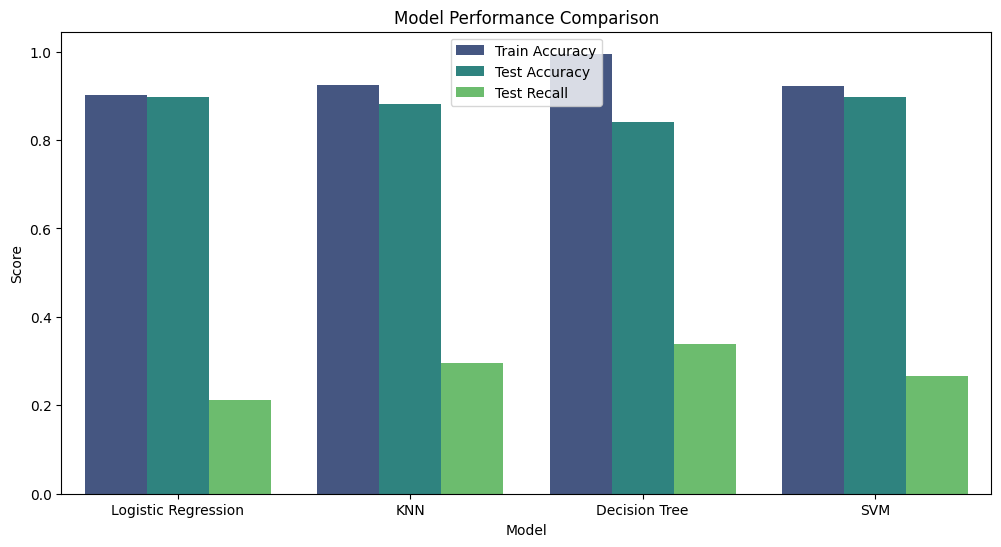

C:\Users\shiva\AppData\Local\Temp\ipykernel_25476\2672006715.py:19: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




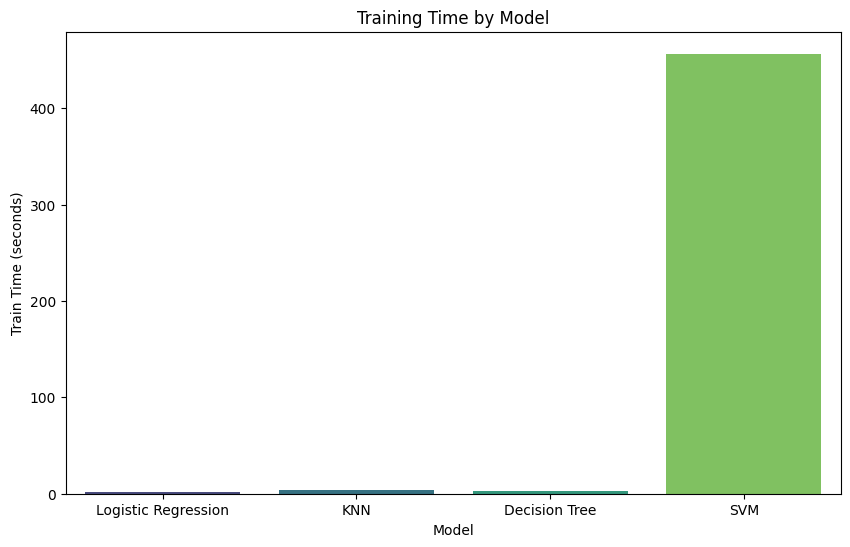

In [76]:
# Convert the results list to DataFrame
results_df_2 = pd.DataFrame(results_2)

# Create a melted DataFrame for easier plotting
results_melted = results_df_2.melt(id_vars='Model', value_vars=['Train Accuracy', 'Test Accuracy', 'Test Recall'],
                                   var_name='Metric', value_name='Score')

# Create a bar plot for accuracy and recall metrics
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Score', hue='Metric', data=results_melted, palette='viridis')
plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()

# Create a separate bar plot for training time
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Train Time', data=results_df_2, palette='viridis')
plt.title('Training Time by Model')
plt.xlabel('Model')
plt.ylabel('Train Time (seconds)')
plt.show()

Even with different hyperparameters, the recall score is low for all the models. Let us explore Decision Tree individually and indentify potentional issues that effect the recall score. 

Extraction:

  - Feature Importance
  - Correlation Analysis
  - Business Insights/ Feature Selection (may need to remove features that don't have direct relation to the client)

### DecisionTreeClassifier (removing economic indications features)

In [51]:
#Creating a new dataset to exclude certain features before modeling
dtc_df = df_cleaned.copy()

- 16 -emp.var.rate: employment variation rate - quarterly indicator (numeric)
- 17 - cons.price.idx: consumer price index - monthly indicator (numeric)
- 18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
- 19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
- 20 - nr.employed: number of employees - quarterly indicator (numeric)

In [52]:
# Removing the below columns as they are more economic indicators that don't relate directly to the characteristics of the the individual clients.
economic_columns = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m','nr.employed']
dtc_df = dtc_df.drop(columns=economic_columns)

In [53]:
dtc_df.head()

age        job  marital  education  default housing loan    contact month  \
0   56  housemaid  married          1       no      no   no  telephone   may   
1   57   services  married          4  unknown      no   no  telephone   may   
2   37   services  married          4       no     yes   no  telephone   may   
3   40     admin.  married          2       no      no   no  telephone   may   
4   56   services  married          4       no      no  yes  telephone   may   

  day_of_week  campaign  previous     poutcome  y pre_contact  
0         mon         1         0  nonexistent  0          no  
1         mon         1         0  nonexistent  0          no  
2         mon         1         0  nonexistent  0          no  
3         mon         1         0  nonexistent  0          no  
4         mon         1         0  nonexistent  0          no

In [54]:
dtc_numeric_cols = ['age', 'education', 'campaign', 'previous']

dtc_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), dtc_numeric_cols),
        ('job_marital_contact_poutcome_pre_contact', OneHotEncoder(), ['job', 'marital', 'contact', 'poutcome', 'pre_contact']),
        ('default_housing_loan', OneHotEncoder(drop='if_binary'), ['default', 'housing', 'loan']),
        ('month_day', OneHotEncoder(), ['month', 'day_of_week'])
    ])

In [55]:
# Define the features and target variable
dtc_X = dtc_df.drop(columns=['y'])  # Features
dtc_y = dtc_df['y']  # Target variable

# Split the data into training and testing sets
dtc_X_train, dtc_X_test, dtc_y_train, dtc_y_test = train_test_split(dtc_X, dtc_y, test_size=0.3, random_state=42)

# Display the shape of the training and testing sets
print("Training set shape:", dtc_X_train.shape, dtc_y_train.shape)
print("Testing set shape:", dtc_X_test.shape, dtc_y_test.shape)

Training set shape: (28831, 14) (28831,)
Testing set shape: (12357, 14) (12357,)


In [56]:
# Define the parameter grid for Decision Tree
dtc_param_grid = {
    'classifier__max_depth': [None, 5, 10, 15, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Define the pipeline
dtc_pipeline = Pipeline(steps=[
    ('preprocessor', dtc_preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Create GridSearchCV instance
dtc_grid_search = GridSearchCV(dtc_pipeline, param_grid=dtc_param_grid, cv=5, scoring='recall', verbose=2)

# Fit the GridSearchCV to the training data
dtc_grid_search.fit(dtc_X_train, dtc_y_train)

Fitting 5 folds for each of 45 candidates, totalling 225 fits
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2; total time=   0.5s
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2; total time=   0.5s
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2; total time=   0.5s
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2; total time=   0.5s
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2; total time=   0.5s
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=5; total time=   0.5s
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=5; total time=   0.5s
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_sample

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'education',
                                                                          'campaign',
                                                                          'previous']),
                                                                        ('job_marital_contact_poutcome_pre_contact',
                                                                         OneHotEncoder(),
                                                                         ['job',
                                                                          'marital',
                                                                          'contact',
                                                                          'poutcome',
                                                                          'pre_contact']),
                                                                        ('default_housing_loan',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['default',
                                                                          'housing',
                                                                          'loan']),
                                                                        ('month_day',
                                                                         OneHotEncoder(),
                                                                         ['month',
                                                                          'day_of_week'])])),
                                       ('classifier',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'classifier__max_depth': [None, 5, 10, 15, 20],
                         'classifier__min_samples_leaf': [1, 2, 4],
                         'classifier__min_samples_split': [2, 5, 10]},
             scoring='recall', verbose=2)

In [57]:
# Display the best parameters and best score
print("Best Parameters:", dtc_grid_search.best_params_)
print("Best Score:", dtc_grid_search.best_score_)

Best Parameters: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Best Score: 0.30144251447477255


Removing the Economic indicators has not improved the model, infact it has decreased the model preformance.

## Extensive Model GridSearch

In [78]:
# Set up logging configuration
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Define models with parameter grids
models = {
    'Logistic Regression': (LogisticRegression(random_state=42), {'classifier__C': np.arange(0.01, 10, 0.2)}),
    'KNN': (KNeighborsClassifier(), {'classifier__n_neighbors':list(range(1, 201, 2))}),
    'Decision Tree': (DecisionTreeClassifier(), {'classifier__max_depth': list(range(0, 101, 2))}),
}

# Initialize an empty list to store results
results_3 = []

# Iterate over models
for model_name, (model, param_grid) in models.items():
    logging.info(f"Training {model_name}...")
    # Pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='recall', verbose = 3)
    
    # Fit the model
    grid_search.fit(X_train, y_train)
    
    # Extract best parameters
    best_params = grid_search.best_params_
    
    # Extract best recall score
    best_recall = grid_search.best_score_
    
    # Evaluate the best model on training and test data
    train_preds = grid_search.predict(X_train)
    test_preds = grid_search.predict(X_test)
    
    train_accuracy = accuracy_score(y_train, train_preds)
    test_accuracy = accuracy_score(y_test, test_preds)
    
    # Evaluate the best model on test data
    test_recall = recall_score(y_test, grid_search.predict(X_test))
    
    # Append results to list
    results_3.append({
        'Model': model_name,
        'Best Parameters': best_params,
        'Best Recall (Cross-Validation)': best_recall,
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy,
        'Test Recall': test_recall
    })
    
    logging.info(f"Completed training {model_name} with result: {json.dumps(results_3, indent=4)}")
    
    logging.info(f"Training {model_name} completed.")

# Convert results list to DataFrame
results_df_3 = pd.DataFrame(results_3)

# Display results
results_df_3

2024-06-09 12:18:25,005 - INFO - Training Logistic Regression...


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ................classifier__C=0.01;, score=0.211 total time=   0.0s
[CV 2/5] END ................classifier__C=0.01;, score=0.208 total time=   0.0s
[CV 3/5] END ................classifier__C=0.01;, score=0.217 total time=   0.0s
[CV 4/5] END ................classifier__C=0.01;, score=0.194 total time=   0.0s
[CV 5/5] END ................classifier__C=0.01;, score=0.205 total time=   0.0s
[CV 1/5] END .classifier__C=0.21000000000000002;, score=0.242 total time=   0.0s
[CV 2/5] END .classifier__C=0.21000000000000002;, score=0.235 total time=   0.0s
[CV 3/5] END .classifier__C=0.21000000000000002;, score=0.228 total time=   0.0s
[CV 4/5] END .classifier__C=0.21000000000000002;, score=0.216 total time=   0.0s
[CV 5/5] END .classifier__C=0.21000000000000002;, score=0.228 total time=   0.0s
[CV 1/5] END .classifier__C=0.41000000000000003;, score=0.243 total time=   0.0s
[CV 2/5] END .classifier__C=0.41000000000000003

2024-06-09 12:18:58,374 - INFO - Completed training Logistic Regression with result: [
    {
        "Model": "Logistic Regression",
        "Best Parameters": {
            "classifier__C": 8.21
        },
        "Best Recall (Cross-Validation)": 0.23427800269905533,
        "Train Accuracy": 0.901122913505311,
        "Test Accuracy": 0.8971837824714737,
        "Test Recall": 0.21283422459893048
    }
]
2024-06-09 12:18:58,375 - INFO - Training Logistic Regression completed.
2024-06-09 12:18:58,375 - INFO - Training KNN...


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END .........classifier__n_neighbors=1;, score=0.321 total time=   0.2s
[CV 2/5] END .........classifier__n_neighbors=1;, score=0.324 total time=   0.2s
[CV 3/5] END .........classifier__n_neighbors=1;, score=0.332 total time=   0.2s
[CV 4/5] END .........classifier__n_neighbors=1;, score=0.327 total time=   0.2s
[CV 5/5] END .........classifier__n_neighbors=1;, score=0.347 total time=   0.2s
[CV 1/5] END .........classifier__n_neighbors=3;, score=0.306 total time=   0.2s
[CV 2/5] END .........classifier__n_neighbors=3;, score=0.305 total time=   0.2s
[CV 3/5] END .........classifier__n_neighbors=3;, score=0.298 total time=   0.2s
[CV 4/5] END .........classifier__n_neighbors=3;, score=0.297 total time=   0.2s
[CV 5/5] END .........classifier__n_neighbors=3;, score=0.324 total time=   0.2s
[CV 1/5] END .........classifier__n_neighbors=5;, score=0.289 total time=   0.2s
[CV 2/5] END .........classifier__n_neighbors=

2024-06-09 12:22:37,241 - INFO - Completed training KNN with result: [
    {
        "Model": "Logistic Regression",
        "Best Parameters": {
            "classifier__C": 8.21
        },
        "Best Recall (Cross-Validation)": 0.23427800269905533,
        "Train Accuracy": 0.901122913505311,
        "Test Accuracy": 0.8971837824714737,
        "Test Recall": 0.21283422459893048
    },
    {
        "Model": "KNN",
        "Best Parameters": {
            "classifier__n_neighbors": 1
        },
        "Best Recall (Cross-Validation)": 0.33009446693657224,
        "Train Accuracy": 0.9948103186646434,
        "Test Accuracy": 0.8472930322893907,
        "Test Recall": 0.3251336898395722
    }
]
2024-06-09 12:22:37,242 - INFO - Training KNN completed.
2024-06-09 12:22:37,243 - INFO - Training Decision Tree...


Fitting 5 folds for each of 51 candidates, totalling 255 fits
[CV 1/5] END .............classifier__max_depth=0;, score=nan total time=   0.0s
[CV 2/5] END .............classifier__max_depth=0;, score=nan total time=   0.0s
[CV 3/5] END .............classifier__max_depth=0;, score=nan total time=   0.0s
[CV 4/5] END .............classifier__max_depth=0;, score=nan total time=   0.0s
[CV 5/5] END .............classifier__max_depth=0;, score=nan total time=   0.0s
[CV 1/5] END ...........classifier__max_depth=2;, score=0.197 total time=   0.0s
[CV 2/5] END ...........classifier__max_depth=2;, score=0.185 total time=   0.0s
[CV 3/5] END ...........classifier__max_depth=2;, score=0.201 total time=   0.0s
[CV 4/5] END ...........classifier__max_depth=2;, score=0.170 total time=   0.0s
[CV 5/5] END ...........classifier__max_depth=2;, score=0.192 total time=   0.0s
[CV 1/5] END ...........classifier__max_depth=4;, score=0.201 total time=   0.0s
[CV 2/5] END ...........classifier__max_depth=4

C:\Users\shiva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning:


5 fits failed out of a total of 255.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\shiva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\shiva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-pack

Model                 Best Parameters  \
0  Logistic Regression         {'classifier__C': 8.21}   
1                  KNN  {'classifier__n_neighbors': 1}   
2        Decision Tree   {'classifier__max_depth': 38}   

   Best Recall (Cross-Validation)  Train Accuracy  Test Accuracy  Test Recall  
0                        0.234278        0.901123       0.897184     0.212834  
1                        0.330094        0.994810       0.847293     0.325134  
2                        0.348178        0.995053       0.837703     0.334759

<Figure size 1400x800 with 0 Axes>

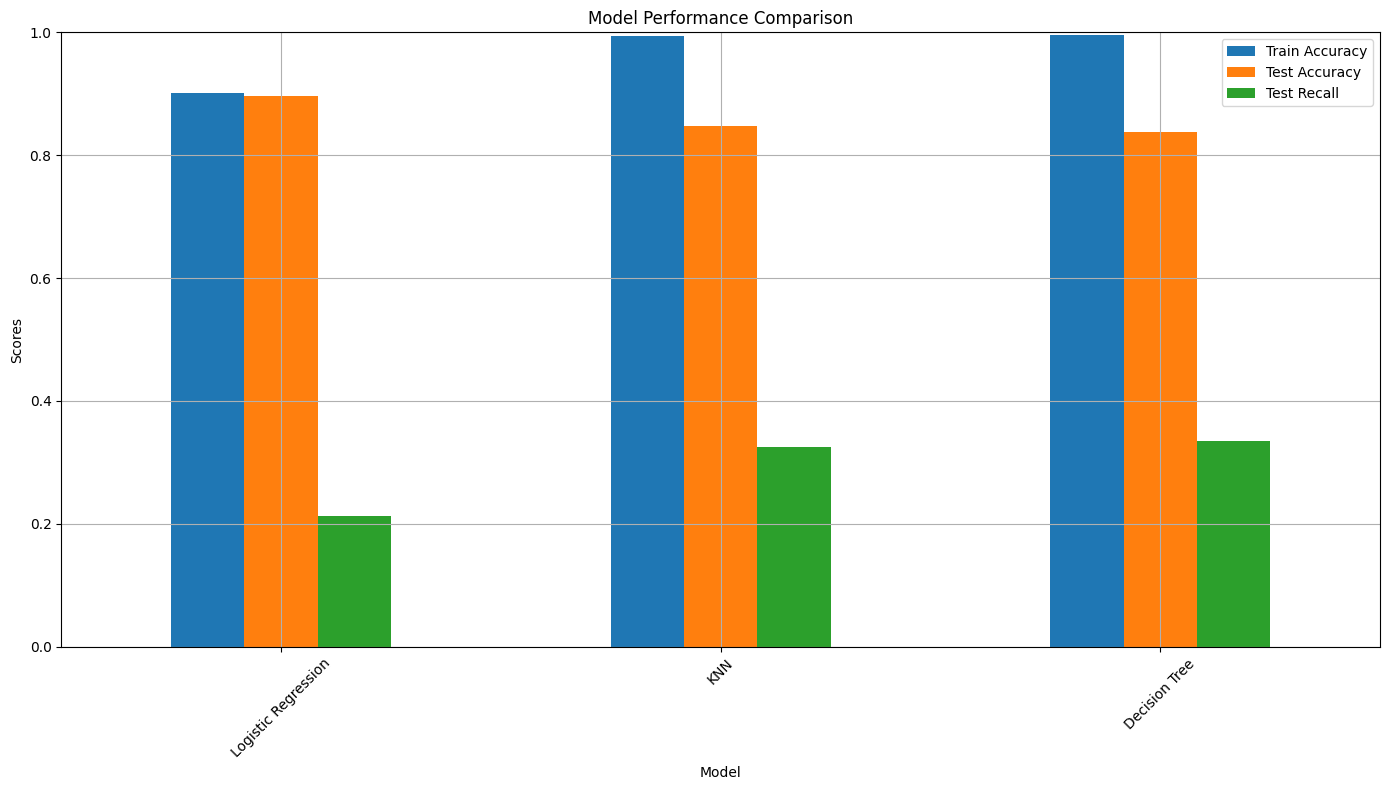

In [79]:
# Plot the results
plt.figure(figsize=(14, 8))
results_df_3.set_index('Model')[['Train Accuracy', 'Test Accuracy', 'Test Recall']].plot(kind='bar', figsize=(14, 8))
plt.title('Model Performance Comparison')
plt.ylabel('Scores')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### DecisionTreeClassifier Model Improvement 

In [84]:
# Set up logging configuration
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Create the DecisionTreeClassifier
decision_tree = DecisionTreeClassifier(random_state=42)

dtc_param_grid = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__splitter': ['best', 'random'],
    'classifier__max_depth': [None, 5, 20, 27, 98, 100],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': [None, 'sqrt', 'log2'],
    'classifier__max_leaf_nodes': [None, 5, 10, 20]
}

# Create the pipeline
decision_tree_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', decision_tree)
])

dtc_grid_search = GridSearchCV(decision_tree_pipeline, dtc_param_grid, cv=5, scoring='recall', verbose=3)

dtc_grid_search.fit(X_train, y_train)

dtc_grid_search

Fitting 5 folds for each of 2592 candidates, totalling 12960 fits
[CV 1/5] END classifier__criterion=gini, classifier__max_depth=None, classifier__max_features=None, classifier__max_leaf_nodes=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__splitter=best;, score=0.329 total time=   0.1s
[CV 2/5] END classifier__criterion=gini, classifier__max_depth=None, classifier__max_features=None, classifier__max_leaf_nodes=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__splitter=best;, score=0.325 total time=   0.1s
[CV 3/5] END classifier__criterion=gini, classifier__max_depth=None, classifier__max_features=None, classifier__max_leaf_nodes=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__splitter=best;, score=0.358 total time=   0.1s
[CV 4/5] END classifier__criterion=gini, classifier__max_depth=None, classifier__max_features=None, classifier__max_leaf_nodes=None, classifier__min_samples_leaf=1

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'education',
                                                                          'campaign',
                                                                          'previous',
                                                                          'emp.var.rate',
                                                                          'cons.price.idx',
                                                                          'cons.conf.idx',
                                                                          'euribor3m',
                                                                          'nr.employed']),
                                                                        ('job_marital_contact_poutcome_pre_contact',
                                                                         OneHotEncoder(),
                                                                         ['job',
                                                                          'marital',
                                                                          'contact',
                                                                          'poutcome',
                                                                          'pre_contact']),
                                                                        ('d...
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'classifier__criterion': ['gini', 'entropy'],
                         'classifier__max_depth': [None, 5, 20, 27, 98, 100],
                         'classifier__max_features': [None, 'sqrt', 'log2'],
                         'classifier__max_leaf_nodes': [None, 5, 10, 20],
                         'classifier__min_samples_leaf': [1, 2, 4],
                         'classifier__min_samples_split': [2, 5, 10],
                         'classifier__splitter': ['best', 'random']},
             scoring='recall', verbose=3)

- DecisionTreeClassifier Feature Importance

In [108]:
decision_tree_model = dtc_grid_search.best_estimator_.named_steps['classifier']

# Get feature importances
feature_importances = decision_tree_model.feature_importances_

# Get the column names after preprocessing
encoded_columns_job_marital_contact_poutcome_pre_contact = preprocessor.named_transformers_['job_marital_contact_poutcome_pre_contact'].get_feature_names_out(['job', 'marital', 'contact', 'poutcome', 'pre_contact']).tolist()
encoded_columns_default_housing_loan = preprocessor.named_transformers_['default_housing_loan'].get_feature_names_out(['default', 'housing', 'loan']).tolist()
encoded_columns_month_day = preprocessor.named_transformers_['month_day'].get_feature_names_out(['month', 'day_of_week']).tolist()

# Concatenate all encoded column names
encoded_columns = encoded_columns_job_marital_contact_poutcome_pre_contact + encoded_columns_default_housing_loan + encoded_columns_month_day

# Combine numeric and encoded column names
all_columns = numeric_columns + encoded_columns

# Create a DataFrame to store feature importances along with column names
feature_importance_df = pd.DataFrame({'Feature': all_columns, 'Importance': feature_importances})

# Display the DataFrame
print(feature_importance_df.sort_values(by = 'Importance',ascending= False).head(50))



                 Feature  Importance
0                    age    0.174173
8            nr.employed    0.157970
7              euribor3m    0.096572
2               campaign    0.084330
1              education    0.066339
33           housing_yes    0.047236
6          cons.conf.idx    0.030377
34              loan_yes    0.023013
29       pre_contact_yes    0.018916
9             job_admin.    0.018343
49       day_of_week_wed    0.015877
18        job_technician    0.015801
22        marital_single    0.015604
10       job_blue-collar    0.015448
21       marital_married    0.015394
46       day_of_week_mon    0.014053
3               previous    0.013979
45       day_of_week_fri    0.013819
48       day_of_week_tue    0.012766
47       day_of_week_thu    0.012463
16          job_services    0.012434
13        job_management    0.011805
30            default_no    0.010358
31       default_unknown    0.010258
23      contact_cellular    0.010062
20      marital_divorced    0.009463
4

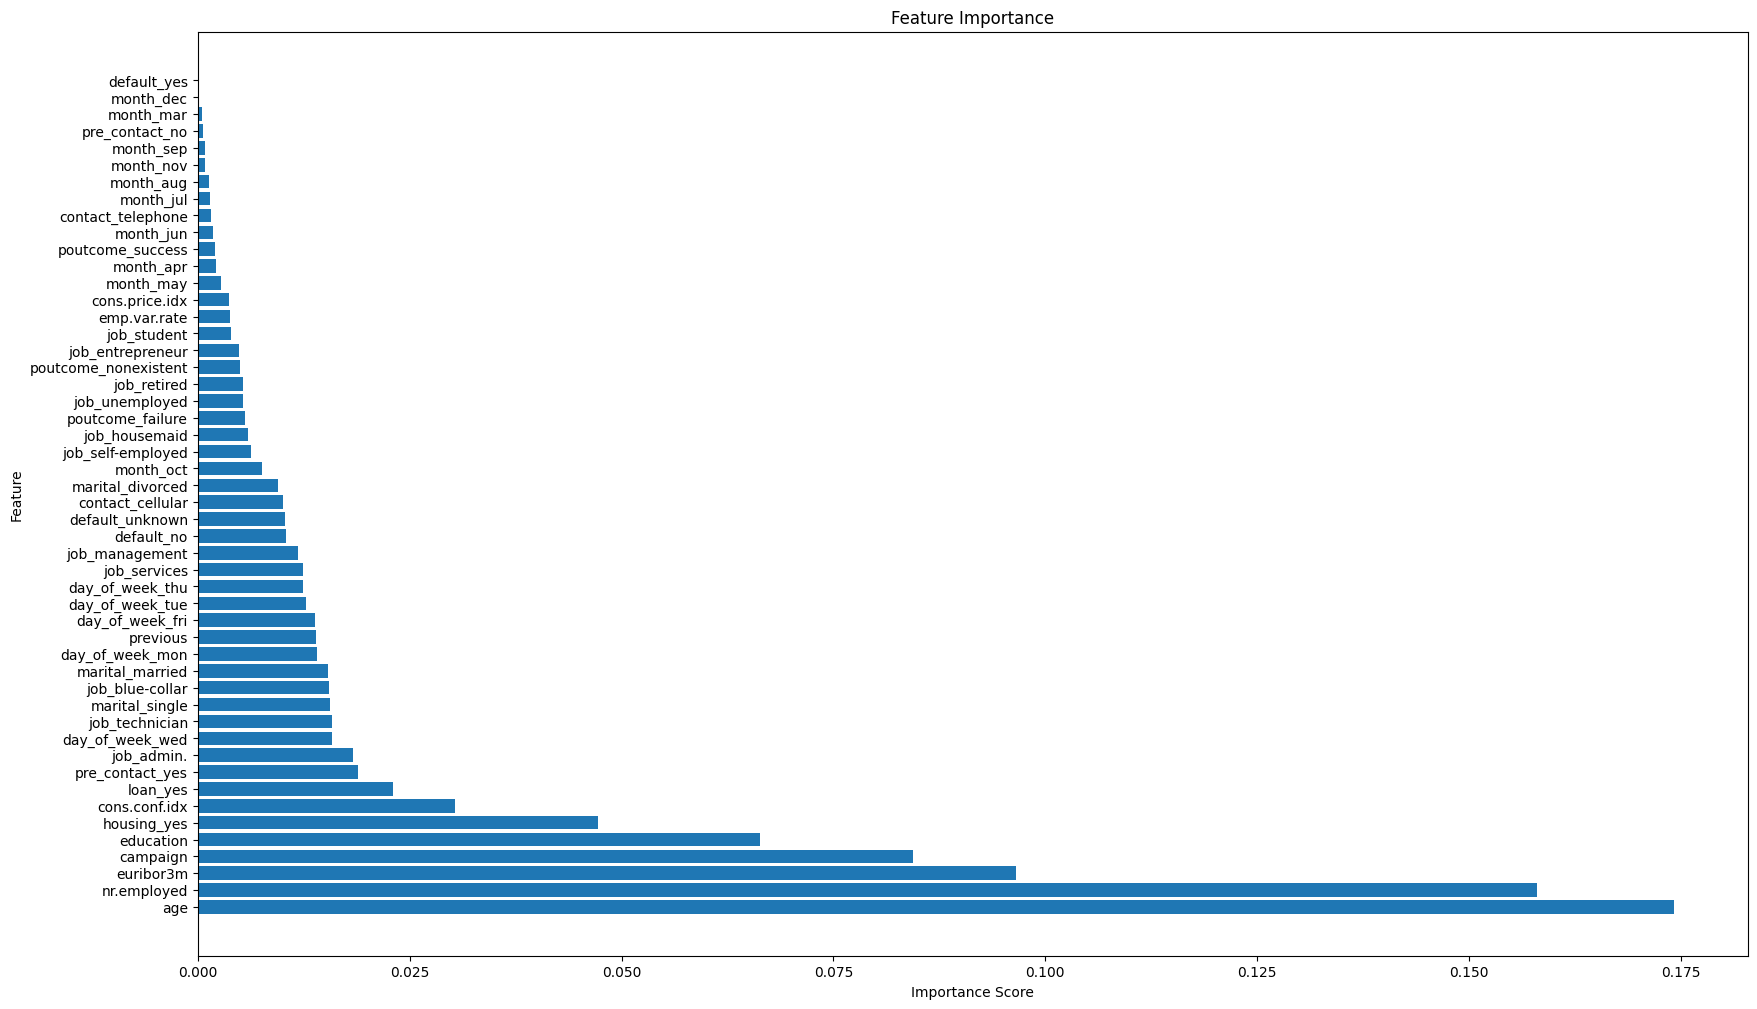

In [120]:
# Extract feature names and importance scores
feature_names = feature_importance_df['Feature']
importance_scores = feature_importance_df['Importance']

# Sort features by importance scores
sorted_indices = importance_scores.argsort()[::-1]
sorted_feature_names = feature_names[sorted_indices]
sorted_importance_scores = importance_scores[sorted_indices]

# Plot the feature importance
plt.figure(figsize=(20, 12))
plt.barh(range(len(sorted_feature_names)), sorted_importance_scores, align='center')
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

Feature Importance: This column represents the importance score assigned to each feature by the decision tree model. The importance scores are normalized so that they sum up to 1.0.

Interpretation:

- The feature importance scores indicate the relative importance of each feature in predicting the target variable (in this case, whether a client subscribed to a term deposit).
- Features with higher importance scores are considered more influential in making predictions, while features with lower importance scores are less influential.
- For example, the most important feature is 'age' with an importance score of 0.174173, followed by 'nr.employed' (number of employees) with an importance score of 0.157970.
- Categorical features such as job, marital status, contact type, etc., also contribute to the model's predictions, as indicated by their respective importance scores.
- Some features may have very low importance scores, indicating that they have minimal impact on the model's predictions.


- DecisionTree GridSearch Best Results

In [125]:
# Get best parameters
best_params = dtc_grid_search.best_params_

# Get best score
best_score = dtc_grid_search.best_score_

print("Best parameters:", best_params)
print("Best score:", best_score)

Best parameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': None, 'classifier__max_features': None, 'classifier__max_leaf_nodes': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__splitter': 'best'}
Best score: 0.34466936572199736


### Next Steps and Improving Models

- Used Best parameters {'classifier__criterion': 'entropy', 'classifier__max_depth': None, 'classifier__max_features': None, 'classifier__max_leaf_nodes': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__splitter': 'best'}

- Remove features with extremley low importance scores. In other words lets use only the top 12 features.

- Increase the threshold for False Negative to improve recall score. 